Code associated with paper "Theta oscillations as a substrate for medial prefrontal-hippocampal assembly interactions"

Michele Nardin, Karola Kaefer, Federico Stella, Jozsef Csicsvari

In this notebook, we will load spiking data, compute cross-correlograms, and compare real data statistics against expectations of GLM models to take into account possible common sensory and oscillatory drivers (models previously fitted - see notebook GLM_CrossVal)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat

In [5]:
# load firing data
fir_CA1 = np.load('data/fir_CA1.npy')
fir_PFC = np.load('data/fir_PFC.npy')
_,N_CA1 = fir_CA1.shape
_,N_PFC = fir_PFC.shape

In [11]:
# load GLM expected firing rates
CA1_glm_firing = np.load('fits/CA1_glm_firing.npy').T
PFC_glm_firing = np.load('fits/PFC_glm_firing.npy').T

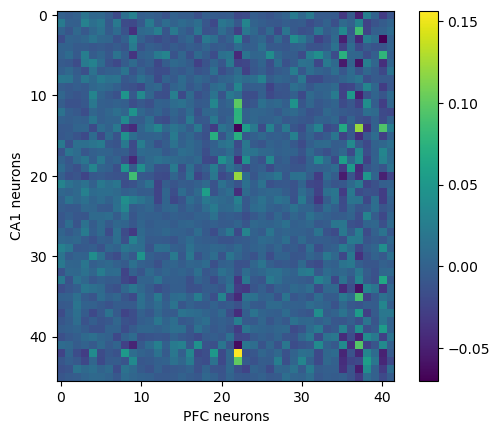

In [36]:
# plot real data across-area correlations at zero delay
plt.imshow(np.corrcoef(fir_CA1.T,fir_PFC.T)[N_CA1:][:,:N_CA1].T)
plt.xlabel('PFC neurons')
plt.ylabel('CA1 neurons')
plt.colorbar()

In [29]:
shifts = np.arange(-80,81) # from -1sec to +1sec
# compute cross-correlations on real data
real_corrs = []
for ish, sh in enumerate(shifts):
    if sh > 0:
        cshift = np.corrcoef(fir_CA1[sh:].T,fir_PFC[:-sh].T)
    if sh == 0:
        cshift = np.corrcoef(fir_CA1.T,fir_PFC.T)
    if sh < 0:
        cshift = np.corrcoef(fir_CA1[:sh].T,fir_PFC[-sh:].T)

    real_corrs.append(cshift[N_CA1:][:,:N_CA1].T)

In [32]:
# compute cross-correlations on simulated data

# store mean and std of cross-correlation matrix - to update in line (Welford method)
corr_matrix = np.zeros([len(shifts),N_CA1,N_PFC]) # average cross-corr
old_M = np.zeros([len(shifts),N_CA1,N_PFC]) # cross-corr previous step
corr_std = np.zeros([len(shifts),N_CA1,N_PFC]) # save STD

for shuffle in range(1000): # many repeats for reliable statistics
    # simulate firing based on GLM models predictions
    yfake1 = np.random.poisson(CA1_glm_firing)
    yfakep = np.random.poisson(PFC_glm_firing)

    for ish, sh in enumerate(shifts):
        if sh > 0:
            cshift = np.corrcoef(np.concatenate([yfake1[sh:].T,yfakep[:-sh].T]))
        if sh == 0:
            cshift = np.corrcoef(np.concatenate([yfake1.T,yfakep.T]))
        if sh < 0:
            cshift = np.corrcoef(np.concatenate([yfake1[:sh].T,yfakep[-sh:].T]))

        cmp = cshift[N_CA1:][:,:N_CA1].T
        old_M[ish]=corr_matrix[ish] # update old cross-corr
        corr_matrix[ish] = corr_matrix[ish] + (cmp-corr_matrix[ish])/(shuffle+1)
        corr_std[ish] = corr_std[ish] + (cmp - corr_matrix[ish])*(cmp - old_M[ish])

# compute STD by square-rooting the variance
corr_std = np.sqrt(corr_std/shuffle)

In [33]:
# save functional correlation matrix
np.save('func_corr.npy',(np.array(real_corrs) - corr_matrix)/corr_std)

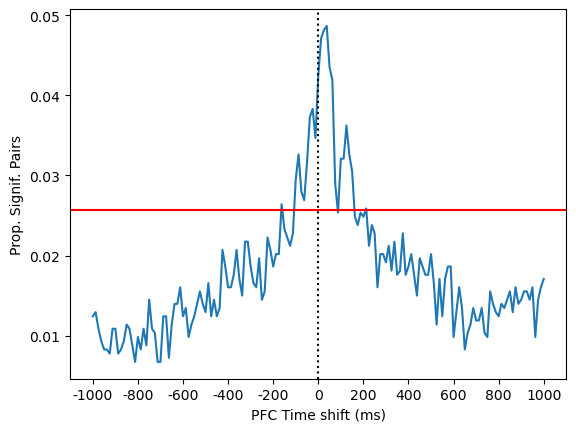

In [34]:
# plot average proportion of FnC cell pairs

avg_abs_c = []
for ish, sh in enumerate(shifts):
    func_corr = (real_corrs[ish] - corr_matrix[ish])/ corr_std[ish]
    avg_abs_c.append(np.nanmean(np.abs(func_corr)>3))
# plot average proportion of functional correlations
plt.plot(shifts,np.flip(avg_abs_c))
plt.xticks(np.arange(-5,6)*16,np.arange(-5,6)*200)
plt.axvline(x=0,color='k',ls='dotted')
# simple statistic, check STD on tails
tails = np.concatenate([avg_abs_c[:60], avg_abs_c[100:]])
plt.axhline(y = np.mean(tails) + 3*np.std(tails), color='red') 
plt.xlabel('PFC Time shift (ms)')
plt.ylabel('Prop. Signif. Pairs')
plt.show()